# Digitizer Self Trigger

This script uses the Digitizer in self Trigger mode.<br>
    
The Signal generator is confige:<br>
DAC frequency: `2GHz`<br>

Channel 1:<br>
 - Sinuse wave form;  
 - amplitude 0.7V; 
 
Channel 2:<br>  
 - Triangular wave form;  
 - amplitude 0.7V;  
          
CH1 should be connected to Digitizer channel 1.<br>
CH2 should be connected to Digitizer channel 2.<br>

The Digitizer is confige:
 - Mode               : DUAL 
 - Sample Rate        : 2GHz
 - Trigger source Ch1 : CH1 at level -0.1V (Chennel 1 self trigger)
 - Trigger source Ch2 : CH2 at level  0.1V (Chennel 2 self trigger)
 - The Digitizer External Trigger threshold is set to 0.7V

This script uses 4 Frames with 4800 samples each.<br>

Start the Digitizer;<br>
 - wait for the MULTIY_FRAME_DONE bit goes back to 'high'.<br>
 
Stop the Digitizer;<br>

Read the DDR memory and polt the signals.<br>

check the proteus registers and close the script.<br>


In [1]:
import os
import sys
srcpath = os.path.realpath('../SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst

In [2]:
%matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt

In [3]:
# Connect to instrument

sid = 6
Debug = True

admin = TepAdmin()
inst = admin.open_instrument(slot_id=sid)

In [4]:
# Get the instrument's *IDN
resp = inst.send_scpi_query('*IDN?')
print(resp)

# Get the DAC mode (8 bits or 16 bits)
resp = inst.send_scpi_query(':SYST:INF:DAC?')
dac_mode = int(resp)
print('DAC {0} bits'.format(dac_mode))

if dac_mode == 16:
    max_dac = 65535
    data_type = np.uint16 
else:
    max_dac = 255
    data_type = np.uint8 
    
half_dac = max_dac / 2.0

# Several initializations ..
inst.send_scpi_cmd('*CLS; *RST')
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':SOUR:FREQ 2.0e9')
inst.send_scpi_cmd(':TRAC:DEL:ALL')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Tabor Electronics,P9082M,000020201231,1.115.0
DAC 8 bits
0, no error


## Configure Generator

In [5]:
# Build two AWG segment that will be used as innput for the digitizer

cycleLen = 1024
numCycles = 1
segLen = cycleLen * numCycles

cycleLen = 1024
numCycles = 8
segLen = cycleLen * numCycles

# Build waveform (sine wave)
x = np.linspace(
    start=0, stop=2 * np.pi * numCycles, num=segLen, endpoint=False)

y = (np.sin(x) + 1.0) * half_dac
y = np.round(y)
y = np.clip(y, 0, max_dac)
y = y.astype(data_type)

# download it to segment 2 of channel 1
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':TRAC:DEF 1,' + str(segLen))
inst.send_scpi_cmd(':TRAC:SEL 1')
inst.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM 1')
inst.send_scpi_cmd(':SOUR:VOLT 0.8')
inst.send_scpi_cmd(':OUTP ON')
# download the waveform to the selected segment
inst.write_binary_data(':TRAC:DATA', y)
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

y = np.sin(x)
y = np.arcsin(y)* 2 * half_dac / np.pi + half_dac
y = np.round(y)
y = np.clip(y, 0, max_dac)
y = y.astype(data_type)

# download it to segment 2 of channel 1
inst.send_scpi_cmd(':INST:CHAN 2')
inst.send_scpi_cmd(':TRAC:DEF 2,' + str(segLen))
inst.send_scpi_cmd(':TRAC:SEL 2')
inst.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM 2')
inst.send_scpi_cmd(':SOUR:VOLT 0.8')
inst.send_scpi_cmd(':OUTP ON')
# download the waveform to the selected segment
inst.write_binary_data(':TRAC:DATA', y)
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error
0, no error


## Setup Digitizer

In [6]:
# Setup the digitizer in two-channels mode
inst.send_scpi_cmd(':DIG:MODE DUAL')
inst.send_scpi_cmd(':DIG:FREQ 2000MHZ')

# Set Trigger level to 0.2V
#inst.send_scpi_cmd(':DIG:TRIG:SELF:LEV -0.1')

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the external-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE CH1')
inst.send_scpi_cmd(':DIG:TRIG:SELF:LEV -0.1')

# Enable capturing data from channel 2
inst.send_scpi_cmd(':DIG:CHAN:SEL 2')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the external-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE CH2')
inst.send_scpi_cmd(':DIG:TRIG:SELF:LEV 0.1')

# Set Trigger level to 0.2V
#inst.send_scpi_cmd(':DIG:TRIG:SELF:LEV 0.1')

# Allocate four frames of 4800 samples
numframes, framelen = 4, 4800
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)

# Select the frames for the capturing 
# (all the four frames in this example)
capture_first, capture_count = 1, numframes
cmd = ":DIG:ACQuire:FRAM:CAPT {0},{1}".format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)

# Clean memory 
inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
print("Set Digitizer: DUAL mode; internal Trigger")


0, no error
Set Digitizer: DUAL mode; internal Trigger


#### Acquire signals into Memory

In [7]:
# Stop the digitizer's capturing machine (to be on the safe side)
inst.send_scpi_cmd(':DIG:INIT OFF')

# Start the digitizer's capturing machine
inst.send_scpi_cmd(':DIG:INIT ON')

print('Waiting for status done bit ..')
loopcount = 0
done = 0
while done == 0:
    resp = inst.send_scpi_query(":DIG:ACQuire:FRAM:STATus?")
    resp_items = resp.split(',')
    done = int(resp_items[1])
    print("{0}. {1}".format(done, resp_items))
    loopcount += 1
    if loopcount == 10:
        print("No Trigger was detected")
        done = 1  
print("Capture Done")

# Stop the digitizer's capturing machine (to be on the safe side)
inst.send_scpi_cmd(':DIG:INIT OFF')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
print("Digitizer: Finish Acquisition")

Waiting for status done bit ..
1. ['1', '1', '0']
Capture Done
0, no error
Digitizer: Finish Acquisition


#### Read all frames from Memory

In [8]:
# Choose which frames to read (all in this example)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')

# Choose what to read 
# (only the frame-data without the header in this example)
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')

# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

wavlen = num_bytes // 2

wav1 = np.zeros(wavlen, dtype=np.uint16)

rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)

# Read the data that was captured by channel 2:
inst.send_scpi_cmd(':DIG:CHAN:SEL 2')

wavlen = num_bytes // 2

wav2 = np.zeros(wavlen, dtype=np.uint16)

rc = inst.read_binary_data(':DIG:DATA:READ?', wav2, num_bytes)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
print("read data from DDR")


Total size in bytes: 38400

0, no error
read data from DDR


## Plot Signals

<IPython.core.display.Javascript object>


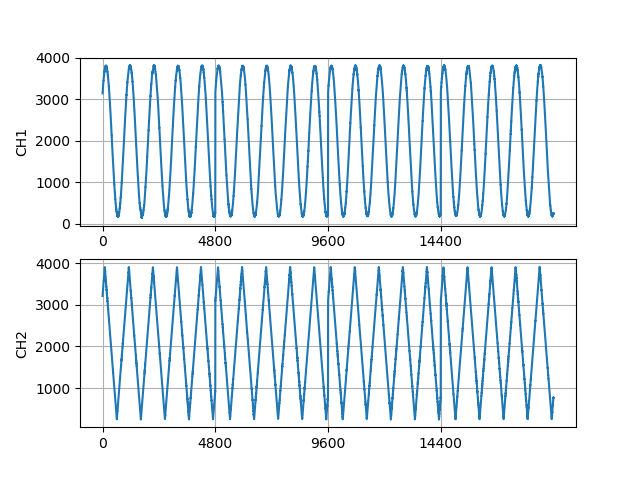

In [9]:
# Plot the samples
totlen = numframes * framelen
x = range(numframes * framelen)
plt.figure(1)
ax1 = plt.subplot(211)
ax1.set_xticks(np.arange(0, totlen, framelen))
ax1.grid(True)
ax1.plot(x, wav1)
ax1.set_ylabel('CH1')

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_xticks(np.arange(0, totlen, framelen))
ax2.grid(True)
ax2.plot(x, wav2)
ax2.set_ylabel('CH2')

plt.show()


## read debug registers

In [10]:
import tempfile
import webbrowser

if Debug == True :
    channb = 1
    cmd = ':INST:CHAN {0}; :SYST:INF:REG?'.format(channb)
    html_str = inst.send_scpi_query(cmd, max_resp_len=200000)
    #print(html_str)
    with tempfile.NamedTemporaryFile('w', delete=False, suffix='.html') as f:
        url = 'file://' + f.name
        f.write(html_str)
    webbrowser.open(url)

## End

In [11]:
# close connection
inst.close_instrument()
admin.close_inst_admin()

0